# Bayesian tri-training for semi-supervised domain adaptation

A tri-training bootstrapped approach to domain adaptation for MNIST to USPS using a Bayesian CNN.

Author: @ysbecca, see my [personal blog](ybecca.github.io) for contact.

Credits go to:

- Kuniaki Saito, Yoshitaka Ushiku, Tatsuya Harada, for their work in "Asymmetric Tri-training for Unsupervised Domain Adaptation" which is used as a base for this approach.
- [Hvass-Labs](http://www.hvass-labs.org/) for the base CNN model for MNIST classification. Their CNN was deepened and adjusted to iteratively for this work.
- [Leo Pauly](https://github.com/leopauly) for the research interest in general.
- Kyle Dorman, Yarin Gal, Alex Kendall for their work in Bayesian deep learning.

In [163]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from datetime import timedelta
from importlib import reload
import math
import time

# Custom scripts.
import ysb
import dataset
import mnist_usps as mnus
import cnn_helper as cn

In [177]:
reload(mnus)
reload(dataset)
reload(cn)
reload(ysb)

<module 'ysb' from '/Users/ysbecca/ysbecca-projects/Domain-Adaptation/MNIST_USPS_Dataset/ysb.py'>

Set parameters.

In [103]:
# Shared net parameters
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

filter_size2 = 5         
num_filters2 = 48    



# Individual net parameters (for now we assume both fully connected layers have the same number of units)
fc_size = 100

# IMAGE PARAMETERS
img_size = 16             # Width and height in pixels.

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

## Load both datasets.

In [4]:
mnist_data, usps_data = dataset.read_datasets()

In [5]:
print("MNIST dataset:")
print("- Training-set:\t\t{}".format(mnist_data.train.num_images))
print("- Test-set:\t\t{}".format(mnist_data.test.num_images))
print("- Validation-set:\t{}".format(mnist_data.valid.num_images))

print("USPS dataset:")
print("- Training-set:\t\t{}".format(usps_data.train.num_images))
print("- Test-set:\t\t{}".format(usps_data.test.num_images))

MNIST dataset:
- Training-set:		49000
- Test-set:		14000
- Validation-set:	7000
USPS dataset:
- Training-set:		7439
- Test-set:		1859


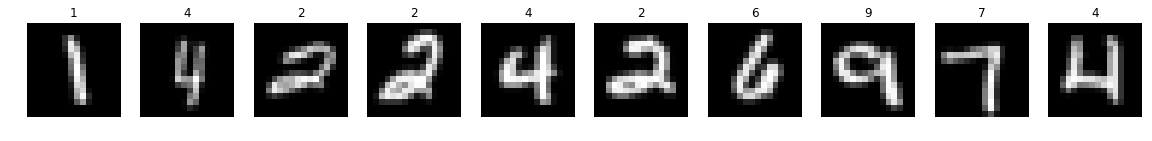

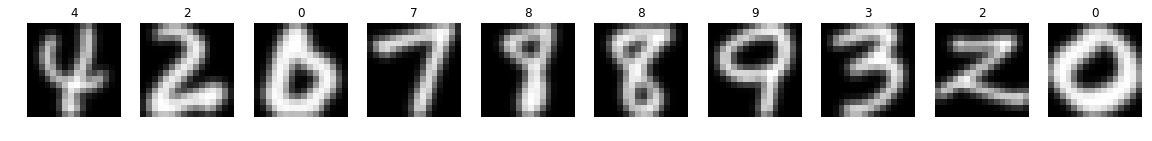

In [6]:
i = 0
to_show = 10
ysb.show_labeled_patches_gray(mnist_data.train.images[i:(i+to_show)], mnist_data.train.cls[i:(i+to_show)])
ysb.show_labeled_patches_gray(usps_data.train.images[i:(i+to_show)], usps_data.train.cls[i:(i+to_show)])

## Build the four networks

The first network, the shared network, will feed into the three tri-training networks: two labeling networks and one target-specific network.

In [197]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

keep_prob = tf.placeholder(tf.float32) # So we can control dropout.
keep_prob_target = tf.placeholder(tf.float32) # Separate dropout rate for the target-only network.

Build TensorFlow graph for the shared network.

In [198]:
shared_net = \
    cn.new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
shared_net = \
    cn.new_conv_layer(input=shared_net,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
shared_net, features = cn.flatten_layer(shared_net)

Now we build the three independent networks, which are identical.

In [199]:
# Labeling network F1
f1_net, _ = cn.new_fc_layer(input=shared_net,       
                         num_inputs=features,
                         num_outputs=fc_size,
                         use_relu=True)
f1_net, f1_w_out = cn.new_fc_layer(input=f1_net,       
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=True, )
#                          dropout_keep_rate=keep_prob)
f1_net, _ = cn.new_fc_layer(input=f1_net,             # This is the classification layer.
                         num_inputs=fc_size,
                         num_outputs=num_classes,            # num_classes = 10
                         use_relu=False)
f1_y_pred = tf.nn.softmax(f1_net)                    
f1_y_pred_cls = tf.argmax(f1_y_pred, dimension=1)


# Labeling network F2
f2_net, _ = cn.new_fc_layer(input=shared_net,
                         num_inputs=features,
                         num_outputs=fc_size,
                         use_relu=True)
f2_net, f2_w_out = cn.new_fc_layer(input=f2_net,          
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=True, )
#                          dropout_keep_rate=keep_prob)
f2_net, _ = cn.new_fc_layer(input=f2_net,          
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=True)
f2_y_pred = tf.nn.softmax(f2_net)                    
f2_y_pred_cls = tf.argmax(f2_y_pred, dimension=1)

# # Labeling network F3
f3_net, _ = cn.new_fc_layer(input=shared_net,
                         num_inputs=features,
                         num_outputs=fc_size,
                         use_relu=True)
f3_net, _ = cn.new_fc_layer(input=f3_net,          
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=True, )
#                          dropout_keep_rate=keep_prob_target)
f3_net, _ = cn.new_fc_layer(input=f3_net,          
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=True)
f3_y_pred = tf.nn.softmax(f3_net)                    
f3_y_pred_cls = tf.argmax(f3_y_pred, dimension=1)

Now we define the cost for each network.

In [200]:
# Cost for the three networks
f1_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=f1_net, labels=y_true))
f2_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=f2_net, labels=y_true))
f3_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=f3_net, labels=y_true))

# Overall tri-network costs, with a constraint for the weights of F1, F2 to force their inputs to be diffferent.
weight_constraint = tf.reduce_sum( \
                        tf.abs( \
                        tf.multiply( \
                        tf.transpose(f1_w_out), f2_w_out)))
cost = f1_cost + f2_cost + f3_cost + weight_constraint
labeling_cost = f1_cost + f2_cost + weight_constraint
target_only_cost = f3_cost

# Optimisation functions
optimizer_all = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
optimizer_f1f2 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(labeling_cost)
optimizer_f3 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(target_only_cost)

# Individual network accuracies
f1_accuracy = tf.reduce_mean(tf.cast(tf.equal(f1_y_pred_cls, y_true_cls), tf.float32))
f2_accuracy = tf.reduce_mean(tf.cast(tf.equal(f2_y_pred_cls, y_true_cls), tf.float32))
f3_accuracy = tf.reduce_mean(tf.cast(tf.equal(f3_y_pred_cls, y_true_cls), tf.float32))

Now we create a new TensorFlow session and initialise the variables.

In [201]:
tf.set_random_seed(1)
np.random.seed(0)

session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 128
test_batch_size = 128

saver = tf.train.Saver()

Helper functions for running optimisation iterations and showing test accuracy.

In [213]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(dataset_train, num_iterations, silent=False, dropout_keep_prob=1.0):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = dataset_train.next_batch(train_batch_size)
        x_batch = x_batch.reshape(len(x_batch), img_size_flat)
        feed_dict_train = {x: x_batch, y_true: y_true_batch, keep_prob: dropout_keep_prob}

        # [optimizer_all, optimizer_f1f2, optimizer_f3]
        session.run(optimizer_all, feed_dict=feed_dict_train)

        # Print status every 250 iterations.
        if i % 250 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(f1_accuracy, feed_dict=feed_dict_train)

            if not silent:
                msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
                print(msg.format(i + 1, acc))

    total_iterations += num_iterations

    end_time = time.time()
    time_dif = end_time - start_time
    if not silent:
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
def print_test_accuracy(dataset_test, show_confusion_matrix=True, quieter=False, silent=False):
    num_test = len(dataset_test.images)
    cls_pred_f1 = np.zeros(shape=num_test, dtype=np.int)
    cls_pred_f2 = np.zeros(shape=num_test, dtype=np.int)
    cls_pred_f3 = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        
        # Get the images and targets from the test-set between index i and j.
        images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset_test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}

        cls_pred_f1[i:j], cls_pred_f2[i:j], cls_pred_f3[i:j] = \
                        session.run([f1_y_pred_cls, f2_y_pred_cls, f3_y_pred_cls], feed_dict=feed_dict)
        i = j

    cls_true = dataset_test.cls

    # Create a boolean array whether each image is correctly classified.
    correct_f1, correct_f2, correct_f3 = \
            (cls_true == cls_pred_f1), (cls_true == cls_pred_f2), (cls_true == cls_pred_f3)
    
    correct_sum_f1, correct_sum_f2, correct_sum_f3 = correct_f1.sum(), correct_f2.sum(), correct_f3.sum()
    acc_f1, acc_f2, acc_f3 = \
        float(correct_sum_f1) / num_test, float(correct_sum_f2) / num_test, float(correct_sum_f3) / num_test

    msg = "Accuracy on test set: F1 {0:.1%}, F2 {1:.1%}, F3 {2:.1%}"
    if not quieter:
        print(msg.format(acc_f1, acc_f2, acc_f3))
    else:
        if not silent:
            print(msg.format(acc_f1, acc_f2, acc_f3))
    
    if show_confusion_matrix:
        # Show confusion matrix for F1 only
        cn.plot_confusion_matrix(cls_true, cls_pred=cls_pred_f1)
    return acc_f1, acc_f2, acc_f3

## First, we train all the networks on the labeled source data set.

- MNIST to USPS

In [203]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

Accuracy on test set: 10.4% (1460 / 14000)


0.10428571428571429

In [204]:
optimize(mnist_data.train, num_iterations=10, silent=False)

Optimization Iteration:      1, Training Accuracy:   8.6%
Time usage: 0:00:03


In [ ]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

In [205]:
optimize(mnist_data.train, num_iterations=20000, silent=True)

Accuracy on test set: F1 98.5%, F2 89.2%, F3 89.8%
[[1374    1    3    0    0    5    2    1    5    1]
 [   0 1549    3    0    0    0    2    4    6    0]
 [   2    1 1403    0    1    3    0    1   10    2]
 [   2    0    5 1403    0   14    0    2   22    7]
 [   1    0    0    0 1373    0    0    4    3    6]
 [   0    0    1    0    0 1242    0    1    4    2]
 [   3    2    1    0    4    8 1350    0    8    0]
 [   0    0    4    0    3    1    0 1434    6    4]
 [   1    0    2    2    1    6    0    0 1327    2]
 [   1    0    0    1    2    7    0    6    4 1339]]


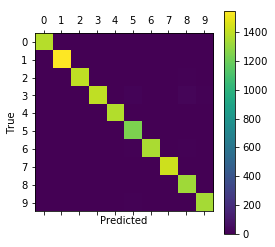

(0.9852857142857143, 0.8923571428571428, 0.8981428571428571)

In [212]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=True)

Now we save the CNN model which has been trained on MNIST.

In [ ]:
saver.save(sess=session, save_path='checkpoints/')

## Now compute prediction and epistemic uncertainty (approximated) on USPS dataset

"We can model epistemic uncertainty in deep learning models using Monte Carlo dropout sampling at test time.
Dropout sampling can be interpreted as sampling from a distribution over models."

Credits:

- Alex Kendall's presentation: https://alexgkendall.com/media/presentations/oxford_seminar.pdf
- Yarin Gal's paper "Dropout as a Bayesian Approximation Representing Model Uncertainty in Deep Learning" http://proceedings.mlr.press/v48/gal16.pdf
- Kyle Dorman's post "Building a Bayesian Deep Learning Classifier" https://medium.com/towards-data-science/building-a-bayesian-deep-learning-classifier-ece1845bc09

Now test on USPS test set, then run the CNN on the entire training set (we treat the training set as if it is completely unlabeled) and save softmax outputs.

In [ ]:
print_test_accuracy(usps_data.test, show_confusion_matrix=True)

In [ ]:
# T is the number of iterations for sampling.
def monte_carlo_preds(dataset_test, T, show_confusion_matrix=True, quieter=False, silent=False):
    num_test = len(dataset_test.images)
    all_cls_preds = np.zeros(shape=(T, num_test, 10), dtype=np.float64)
    cls_true = dataset_test.cls
    
    if num_test == 0:
        return [], []
    
    for k in range(T):
        i = 0
        cls_preds = np.zeros(shape=(num_test, 10), dtype=np.float64)
        
        while i < num_test:
            j = min(i + test_batch_size, num_test)
            curr_batch_size = j - i

            # Get the images and targets from the test-set between index i and j.
            images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
            labels = dataset_test.labels[i:j, :]
            feed_dict = {x: images, y_true: labels, keep_prob: 0.1}

            # For each T iterations, we want all the softmax outputs from each prediction (N, 10)
            # where N is the input size. all_cls_preds should have shape (T, N, 10).
            cls_preds[i:j] = session.run(y_pred, feed_dict=feed_dict)
            i = j

        all_cls_preds[k] = cls_preds

    # (N, 10)
    prediction_probabilities = np.mean(all_cls_preds, axis=0)

    # (N) one variance for each input.
    prediction_variances = np.apply_along_axis(predictive_entropy, axis=1, arr=prediction_probabilities) 

    return prediction_probabilities, prediction_variances

def predictive_entropy(prediction_probabilities):
    return -1 * np.sum(np.log(prediction_probabilities) * prediction_probabilities, axis=0)

def retrieve_predictions(dataset):
    ''' Retrieves the probabilities (not predicted classes) on the given DataSet object. '''
    num_test = len(dataset.images)

    # Allocate an array for the class probabilities which will be calculated in batches and added
    # onto this array; this first element is a dummy to maintain shape as we will add in batches.
    cls_prob = np.zeros(shape=(1, num_classes), dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        images = dataset.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset.labels[i:j, :]
        feed_dict = {x: images, y_true: labels, keep_prob: 1.0}

        # Save the softmax output.
        cls_prob = np.concatenate((cls_prob, session.run(y_pred, feed_dict=feed_dict)), axis=0)
        i = j
    
    cls_prob = np.delete(cls_prob, 0, 0) # Remove the first dummy element now.
    return cls_prob


## Experimenting with different thresholds, number of iterations, & threshold rates.

Remember to reset the CNN model back to the checkpoint before each new experiment, as well as re-designating the dataset so that all MNIST images are training images, and the USPS set is divided into test (labelled) and train (unlabelled).

In [ ]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(mnist_data, usps_data)

In [ ]:
preds, uncertainties = monte_carlo_preds(usps_data.test, 50, show_confusion_matrix=True, quieter=True)

First we will demonstrate that cases exist where bootstrapping using the softmax threshold would result in mislabelling, whereas the epistemic uncertainty provides a warning that the classifier is uncertain.

In [ ]:
i = 0
to_show = 20

printed_uncertainty = [round(a, 4) for a in uncertainties]
print("Labels: Epistemic uncertainty, softmax prediction, actual class.")

ysb.show_images_with_three_labels_gray(usps_data.test.images[i:(i+to_show)], printed_uncertainty[i:(i+to_show)], \
                                       np.argmax(preds[i:to_show], axis=1), usps_data.test.cls[i:to_show])

Now we want to calculate, using the test round above, what the softmax threshold should be. We will look at the epistemic uncertainty for all the cases where the true class is different from the softmax prediction.

In [ ]:
preds, uncertainties, usps_data.test.cls

case_epi_unc = []
for i, pred in enumerate(np.argmax(preds, axis=1)):
    if(pred != usps_data.test.cls[i]):
        case_epi_unc.append(uncertainties[i])

print("For the USPS test set:")
print("  - " + str(len(case_epi_unc)) + " cases.")
print("  - Mean uncertainty: " + str(np.mean(case_epi_unc)))
print("  - Maximum uncertainty: " + str(np.max(case_epi_unc)))
print("  - Minimum uncertainty: " + str(np.min(case_epi_unc)))

ysb.plot_with_legend(np.arange(len(case_epi_unc)), [np.sort(case_epi_unc)], ["USPS test"], "Cases", "Uncertainty")

### Experiment 1: repeated iterations of labeling unlabeled images with LOW epistemic uncertainty.

In [ ]:
bootstrap_iterations = 75
exp1_acc = []
exp1_adds = []

print("-- Experiment 1 --")

for i in range(bootstrap_iterations):
    # Run Monte Carlo sampling iterations to calculate epistemic uncertainty.
    preds, uncertainties = monte_carlo_preds(data.usps_train, 50, show_confusion_matrix=False, quieter=True)
    selected = np.where(uncertainties < 0.3, 1, 0)
    
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
    
    exp1_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp1_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

In [ ]:
print("Best percent accuracy: " + str(np.max(exp1_acc)))

In [ ]:
ysb.plot_with_legend(np.arange(len(exp1_acc)), [exp1_acc], ["Accuracy"], "Iterations", "Accuracy")
ysb.plot_with_legend(np.arange(len(exp1_adds)), [exp1_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 2: repeated iterations of labeling unlabeled images with LOW epistemic uncertainty if the softmax output is HIGH.

In [ ]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(mnist_data, usps_data)

In [ ]:
exp2_acc = []
exp2_adds = []

print("-- Experiment 2 --")

for i in range(bootstrap_iterations):
    usps_train_preds = retrieve_predictions(data.usps_train)
    softmax_selected = cn.split_by_threshold(0.99, usps_train_preds, silent=True)
    
    preds, uncertainties = monte_carlo_preds(data.usps_train, 100, show_confusion_matrix=False, quieter=True)
    bay_selected = np.where(uncertainties < 0.3, 1, 0)
    
    selected = np.zeros((len(bay_selected)))
    for j, s in enumerate(softmax_selected):
        if s > 0 and bay_selected[j] > 0:
            selected[j] = 1
    
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
        
    exp2_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp2_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

In [ ]:
print("Best percent accuracy: " + str(np.max(exp2_acc)))

In [ ]:
ysb.plot_with_legend(np.arange(len(exp2_acc)), [exp2_acc], ["Accuracy"], "Iterations", "Accuracy")
ysb.plot_with_legend(np.arange(len(exp2_adds)), [exp2_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 3: repeated iterations of labeling unlabeled images with lower softmax output IF the epistemic uncertainty is low (ie, trust uncertainty more than the softmax output)

In [ ]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(mnist_data, usps_data)

In [ ]:
exp3_acc = []
exp3_adds = []

print("-- Experiment 3 --")

for i in range(bootstrap_iterations):
    usps_train_preds = retrieve_predictions(data.usps_train)
    softmax_selected = cn.split_by_threshold(0.7, usps_train_preds, silent=True)
    
    preds, uncertainties = monte_carlo_preds(data.usps_train, 100, show_confusion_matrix=False, quieter=True)
    bay_selected = np.where(uncertainties < 0.3, 1, 0)
    
    selected = softmax_selected
    for j, s in enumerate(softmax_selected):
        if bay_selected[j] > 0:
            selected[j] = 0 # Unselect the ones
    
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
        
    exp3_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp3_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

In [ ]:
print("Best percent accuracy: " + str(np.max(exp3_acc)))

In [ ]:
ysb.plot_with_legend(np.arange(len(exp3_acc)), [exp3_acc], ["Accuracy"], "Iterations", "Accuracy")
ysb.plot_with_legend(np.arange(len(exp3_adds)), [exp3_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 4: softmax threshold only.

In [ ]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(mnist_data, usps_data)

In [ ]:
exp4_acc = []
exp4_adds = []

print("-- Experiment 4 --")

for i in range(bootstrap_iterations):
    # print("Round " + str(i) + ":", end=" ")

    usps_train_preds = retrieve_predictions(data.usps_train)
    selected = cn.split_by_threshold(0.99, usps_train_preds, silent=True)
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
        
    exp4_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, usps_train_preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp4_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

## Comparison from both experiments.

In [ ]:
x_range = min(len(exp1_acc), len(exp2_acc), len(exp3_acc), len(exp4_acc))

In [ ]:
ysb.plot_with_legend(np.arange(x_range), [exp1_acc[:x_range], exp2_acc[:x_range], exp3_acc[:x_range], exp4_acc[:x_range]], ["Exp 1", "Exp 2", "Exp 3", "Exp 4"], "Iterations", "Accuracy")

In [ ]:
ysb.plot_with_legend(np.arange(x_range), [exp1_adds[:x_range], exp2_adds[:x_range], exp3_acc[:x_range], exp4_acc[:x_range]], ["Exp 1", "Exp 2", "Exp 3", "Exp 4"], "Iterations", "No. images added per iteration")

## Close TensorFlow session

Releases all resources! Run only when prepared to lose saved CNN model.

In [214]:
session.close()